<a href="https://colab.research.google.com/github/Masoud-Ghasemian/BERT/blob/master/Sentiment_Analysis_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 675kB 11.4MB/s 
     |████████████████████████████████| 3.8MB 56.5MB/s 
     |████████████████████████████████| 1.1MB 48.9MB/s 
     |████████████████████████████████| 890kB 54.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=213120b68067160919fe8ccf4af22515417dd60d074ea11d90904fc9a051ba88
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [9]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)


HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###Data Exploration

In [10]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 63.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 17.3MB/s]


In [11]:
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


Text(0, 0.5, 'Number of Review')

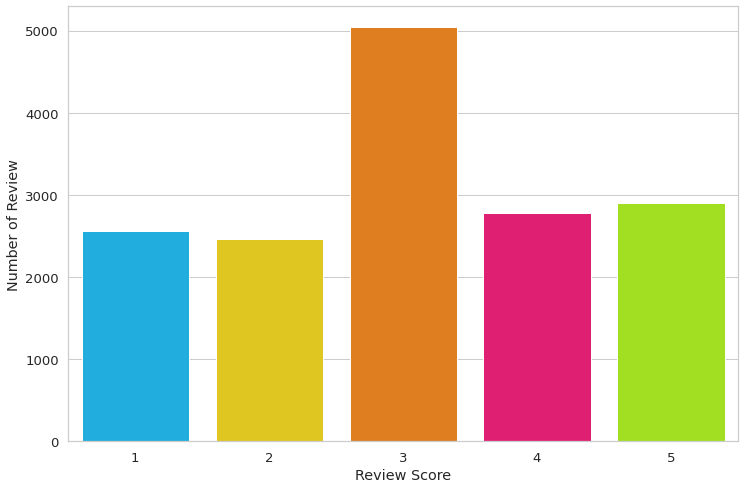

In [13]:
sns.countplot(df.score)
plt.xlabel('Review Score')
plt.ylabel('Number of Review')

In [14]:
def to_sentiment (rating):
  rating = int(rating)
  if rating <=2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

In [15]:
df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo,0
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo,0
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo,0
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo,0
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo,0


In [17]:
class_names = ['negative', 'neutral', 'positive']

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

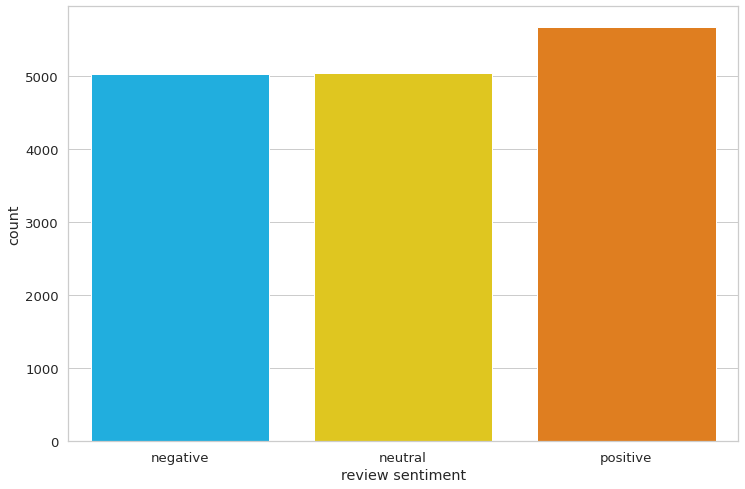

In [18]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

#Data Preprocessing

In [19]:
PRE_TRAINED_MODEL_NAME = 'bert_base_cased'

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [22]:
sample_text = 'When was I last outside? I am stuck at home for 2 weeks'

In [ ]:
tokens = tokenizer.tokenize(sample_text)

In [ ]:
print(tokens)

['When', 'I', 'went', 'to', 'beach', ',', 'I', 'swam', 'with', 'my', 'girlfriend']


In [ ]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [ ]:
print(token_ids)

[1332, 146, 1355, 1106, 4640, 117, 146, 18065, 1114, 1139, 6124]


In [ ]:
### Special Tokens

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [ ]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [ ]:
encoding = tokenizer.encode_plus(sample_text, 
                            max_length = 32,
                            add_special_tokens = True ,
                            pad_to_max_length = True,
                            return_attention_mask = True,
                            return_token_type_ids = False,
                            return_tensors = 'pt'
                            )

encoding.keys()


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding

{'input_ids': tensor([[  101,  1332,   146,  1355,  1106,  4640,   117,   146, 18065,  1114,
          1139,  6124,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

In [ ]:
len(encoding['input_ids'][0])

32

In [ ]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
##Choosing Sequence Length

In [ ]:
token_lens = []
for txt in df.content:
  tokens = tokenizer.encode(txt, max_length = 512)
  token_lens.append(len(tokens))

In [ ]:
len(token_lens)

15746

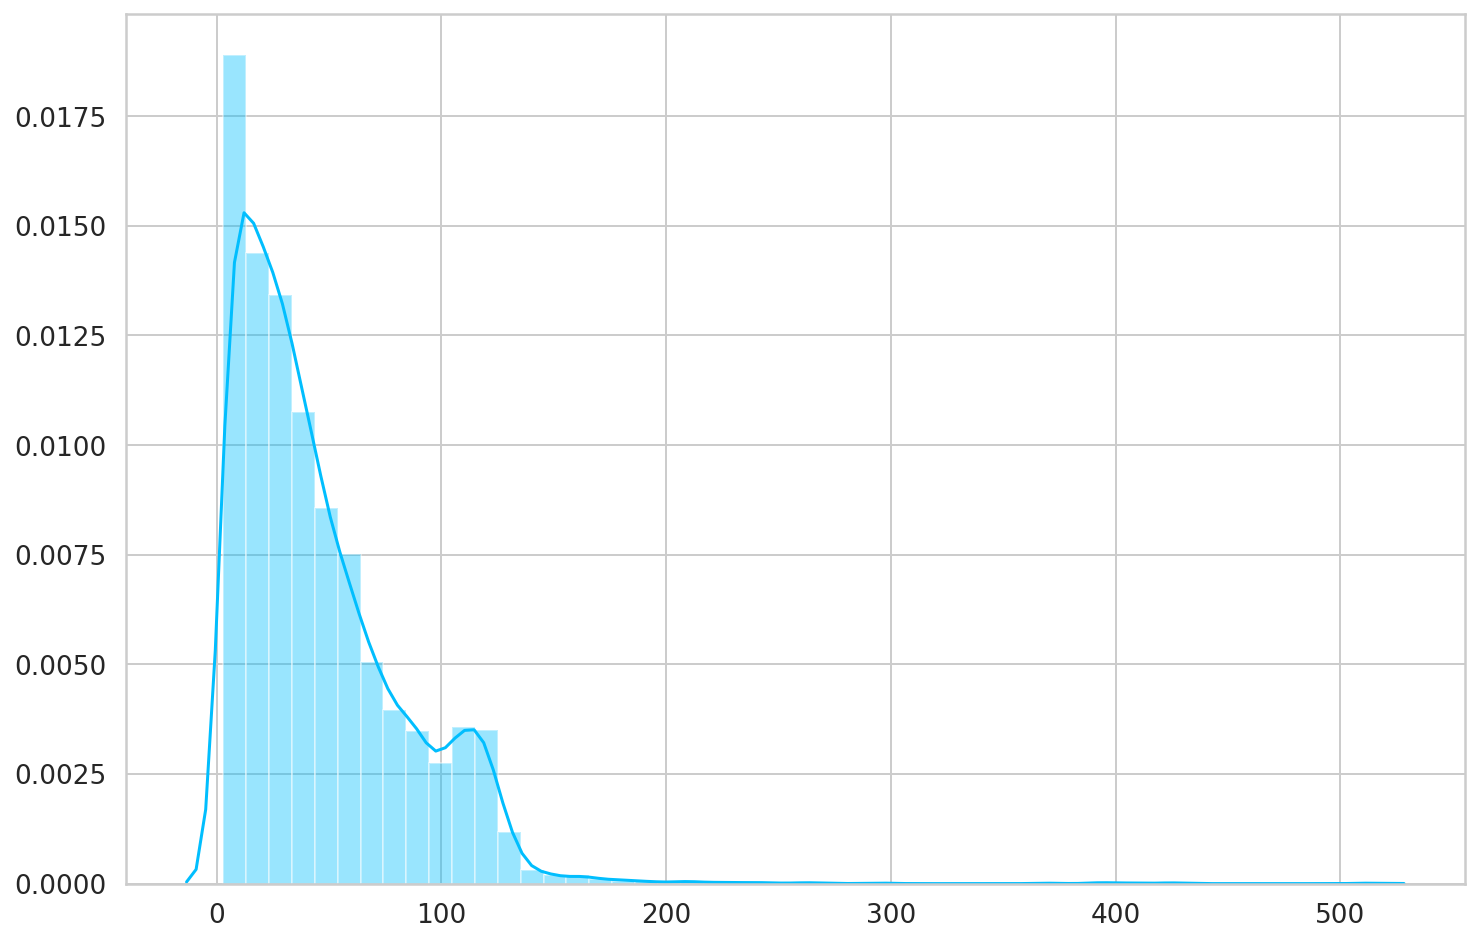

In [ ]:
sns.distplot(token_lens)

In [ ]:
### Create a Dataset

In [ ]:
class GPReviewDataset (data.Dataset):

  def __init__(self, review, target, tokenizer, max_len):
    self.review = review
    self.target = target 
    self.tokenizer = tokenizer
    self.max_len = max_len 

  def __len__(self):
    return(len(self.review))

  def __getitem__(self, item):
    review = str(self.review[item])
    encoding = tokenizer.encode_plus(
      review,
      max_length = self.max_len,
      add_special_tokens = True ,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_token_type_ids = False,
      return_tensors = 'pt'
    )

    return {
        'review_text' : review,
        'input_ids' : encoding['input_ids'],
        'attention_mask' : encoding['attention_mask'],
        'targets' : torch.tensor(self.target[item], dtype = torch.long)
    }




In [ ]:
MAX_LEN = 160
BATCH_SIZE = 16
EPOCHS = 50


In [ ]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

In [ ]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(12596, 12)
(1575, 12)
(1575, 12)


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
      review = df.content.to_numpy(),
      target = df.sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return data.DataLoader(
      ds,
      batch_size = batch_size,
      num_workers = 4
  )

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [ ]:
data = next(iter(train_data_loader))

In [ ]:
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 1, 160])
torch.Size([16, 1, 160])
torch.Size([16])


In [ ]:
!pip install -q -U watermark

In [ ]:
bert_model =transformers.BertModel.from_pretrained('bert-base-cased' )

In [ ]:
last_hidden_state, pooled_output = bert_model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask']
)

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
pooled_output.shape

torch.Size([1, 768])

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
## Building Sentiment Classifier

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert =transformers.BertModel.from_pretrained('bert-base-cased' )
    self.drop = nn.Dropout(p = 0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim = 1)
    self. n_classes =n_classes

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    output = self.drop(pooled_output)
    output = self.out(output)
    return self.softmax(output)




In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
input_ids = data['input_ids'].view(16,160).to(device)
attention_mask = data['attention_mask'].view(16,160).to(device)


In [ ]:
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 160])
torch.Size([16, 160])


In [ ]:
model(input_ids, attention_mask)

tensor([[0.4322, 0.1834, 0.3844],
        [0.5181, 0.1313, 0.3506],
        [0.2610, 0.1298, 0.6092],
        [0.5356, 0.1134, 0.3510],
        [0.5713, 0.1846, 0.2441],
        [0.3432, 0.1646, 0.4922],
        [0.4114, 0.1010, 0.4875],
        [0.3226, 0.2201, 0.4572],
        [0.3351, 0.1559, 0.5090],
        [0.2529, 0.1944, 0.5527],
        [0.4329, 0.1641, 0.4030],
        [0.3739, 0.2429, 0.3832],
        [0.5519, 0.0908, 0.3573],
        [0.4622, 0.1340, 0.4038],
        [0.3933, 0.1603, 0.4464],
        [0.3640, 0.1883, 0.4477]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
###Training

In [ ]:
optimizer = transformers.AdamW(model.parameters(), lr = 2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS
scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].view(16,160).to(device)
    attention_mask = d['attention_mask'].view(16,160).to(device)
    targets = d['targets'].to(device)

    outputs = model(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    _, preds =  torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    return correct_predictions.double() / n_examples , np.mean(losses)




In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad:
    for d in data_loader:
      input_ids = d['input_ids'].view(16,160).to(device)
      attention_mask = d['attention_mask'].view(16,160).to(device)
      targets = d['targets'].to(device)

      outputs = model(
          input_ids = input_ids,
          attention_mask = attention_mask
      )
      _, preds =  torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
history = []
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-'*10)
  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train)
  )
  print(f'Train loss = {train_loss} accuracy = {train_acc}')




Epoch 1/50
----------
Train loss = 1.0476694107055664 accuracy = 0.0007939028262940616
Epoch 2/50
----------
Train loss = 1.0444045066833496 accuracy = 0.0008732931089234678
Epoch 3/50
----------
Train loss = 1.040070652961731 accuracy = 0.0006351222610352493
Epoch 4/50
----------
Train loss = 0.9049623608589172 accuracy = 0.0011114639568116863
Epoch 5/50
----------
Train loss = 0.8905735015869141 accuracy = 0.0011908542394410925
Epoch 6/50
----------
Train loss = 0.7904880046844482 accuracy = 0.0012702445220704986
Epoch 7/50
----------
Train loss = 0.7112404704093933 accuracy = 0.0012702445220704986
Epoch 8/50
----------
Train loss = 0.7074416279792786 accuracy = 0.0012702445220704986
Epoch 9/50
----------
Train loss = 0.6431098580360413 accuracy = 0.0012702445220704986
Epoch 10/50
----------
Train loss = 0.6172838807106018 accuracy = 0.0012702445220704986
Epoch 11/50
----------
Train loss = 0.5934918522834778 accuracy = 0.0012702445220704986
Epoch 12/50
----------
Train loss = 0.5815

In [ ]:
len(df_val)

1575

In [ ]:
len(df_train)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:

%%time

best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc